# Bayes Model

In [1]:
%pip install numpy scikit-learn pandas boto3 matplotlib seaborn python-dotenv


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from io import BytesIO
from pathlib import Path
import pandas as pd
import seaborn as sn
import joblib
import dotenv
import boto3
import logging
import os
import uuid
import sys
from datetime import datetime, timezone

In [3]:
DOTENV_PATH = os.environ.get('DOTENV_PATH', './../.env')

if dotenv.load_dotenv(dotenv_path=DOTENV_PATH) == False:
    print(f'no environment have been loaded from .env path \"{DOTENV_PATH}\"')

In [4]:
LOG_LEVEL = 'INFO'
LOCAL_DATASET_PATH = os.environ.get('LOCAL_DATASET_PATH', '')
IMPORTED_DATASET_S3_KEY = os.environ.get('IMPORTED_DATASET_S3_KEY', '')
IMPORTED_BAYES_S3_KEY = os.environ.get('IMPORTED_BAYES_S3_KEY', '')
PUSH_MODEL_DUMP_TO_S3_ENABLED = os.environ.get('PUSH_MODEL_DUMP_TO_S3_ENABLED', 'true').lower() == 'true'
TMP_DIR = os.environ.get('TMP_DIR', '/tmp/pink-twins')
S3_BUCKET_NAME = os.environ.get('BUCKET_NAME', 'pink-twins-bucket')
S3_BUCKET_FOLDER = os.environ.get('S3_MODELS_BUCKET_FOLDER', '')
S3_ACCESS_KEY_ID = os.environ.get('S3_ACCESS_KEY_ID', '')
S3_SECRET_ACCESS_KEY = os.environ.get('S3_SECRET_ACCESS_KEY', '')
AUTHOR = os.environ.get('AUTHOR', 'undefined')

In [5]:
# Ensure that the temporary folder exist and create one if it doesn't exists
Path(TMP_DIR).mkdir(parents=True, exist_ok=True)

In [6]:
# Set logger format
logging.basicConfig(
    format="%(levelname)s | %(asctime)s | %(message)s",
    datefmt="%Y-%m-%dT%H:%M:%SZ",
    encoding='utf-8',
    level=logging.getLevelName(LOG_LEVEL),
    stream=sys.stdout,
)

In [7]:
if LOCAL_DATASET_PATH != '':
    try:
        df = pd.read_csv(LOCAL_DATASET_PATH)
    except Exception as err:
        logging.fatal(f'failed to load dataset at path {LOCAL_DATASET_PATH}: {err}')
elif IMPORTED_DATASET_S3_KEY != '':
    try:
        # Create an S3 client
        s3 = boto3.client('s3', aws_access_key_id=S3_ACCESS_KEY_ID, aws_secret_access_key=S3_SECRET_ACCESS_KEY)

        # Download the dump file from S3 into memory
        response = s3.get_object(Bucket=S3_BUCKET_NAME, Key=IMPORTED_DATASET_S3_KEY)
        df_bytes = BytesIO(response['Body'].read())

        # Load the variable back from the dump data
        df = joblib.load(df_bytes)

    except Exception as err:
        logging.fatal(f'failed to load dataset {IMPORTED_DATASET_S3_KEY} from S3 bucket: {err}')
else:
    logging.fatal('no source dataset have been defined')

In [8]:
# Save accident severities to compare later model prediction
target = df['Accident_Severity']

# Then drop accident severity from dataset to enable model prediction
# from the other features
df = df.drop(['Accident_Severity'], axis='columns')

# Separate the dataset in a training and testing set
x_train , x_test, y_train, y_test = train_test_split(df, target, test_size=0.33)

In [9]:
if IMPORTED_BAYES_S3_KEY != '':
    try:
        # Create an S3 client
        s3 = boto3.client('s3', aws_access_key_id=S3_ACCESS_KEY_ID, aws_secret_access_key=S3_SECRET_ACCESS_KEY)
        imported_model_id = IMPORTED_BAYES_S3_KEY.split('/')[-1]
        imported_model_file = f'{TMP_DIR}/{imported_model_id}'
        
        # Download the dump file from S3
        response = s3.download_file(Bucket=S3_BUCKET_NAME, Key=IMPORTED_BAYES_S3_KEY,
            Filename=imported_model_file)

        # Load the variable back from the dump data
        model = joblib.load(imported_model_file)

    except Exception as err:
        logging.fatal(f'failed to load dataset {IMPORTED_BAYES_S3_KEY} from S3 bucket: {err}')
else:
    # Create model and train it on the training set
    model = GaussianNB()
    model.fit(x_train, y_train)

In [10]:
# Make predictions from the testing dataset and then compute the confusion
# matrix to evaluate model accuracy
y_pred = model.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

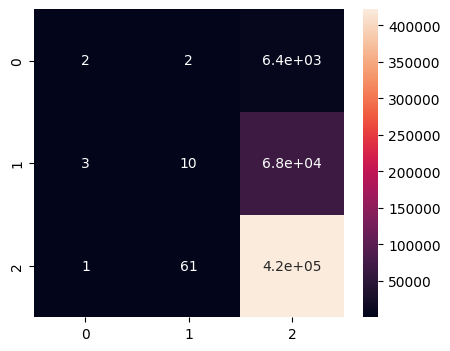

In [11]:
# Display the confusion matrix
plt.figure(figsize = (5,4))
sn.heatmap(conf_matrix, annot=True)
plt.show()

In [14]:
# Compute model accuracy, precision, recall, and F1-score
accuracy = model.score(x_test, y_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.8507207363318007
Precision: 0.7468810552608861
Recall: 0.8507207363318007
F1-score: 0.782244934063831


In [ ]:
if IMPORTED_BAYES_S3_KEY == '' and PUSH_MODEL_DUMP_TO_S3_ENABLED:
    model_id = uuid.uuid4()
    key = f'{S3_BUCKET_FOLDER}/bayes/{model_id}.joblib'

    try:
        model_id = uuid.uuid4()
        tmp_file = f'{TMP_DIR}/{model_id}.joblib'

        joblib.dump(model, tmp_file)

        s3 = boto3.client('s3', aws_access_key_id=S3_ACCESS_KEY_ID, aws_secret_access_key=S3_SECRET_ACCESS_KEY)
        s3.upload_file(Bucket=S3_BUCKET_NAME, Key=key, Filename=tmp_file,
                      ExtraArgs={
                          'Metadata': {
                          'author': AUTHOR,
                          'accuracy': str(accuracy),
                          'date': datetime.now(timezone.utc).astimezone().isoformat(),
                          'training_dataset_key': IMPORTED_DATASET_S3_KEY,
        }})

        logging.info(f'successfully pushed model as: {key}')
    except Exception as err:
        logging.fatal(f'failed to push model {key}: {err}')
